# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

**Описание данных**

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг. Общая информация

In [59]:
# импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter("ignore")
from scipy import stats as st

In [60]:
# открываем файлы, изучаем общую информацию

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

display(calls, calls.info())
display(internet, internet.info())
display(messages, messages.info())
display(tariffs, tariffs.info())
display(users, users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


None

**Вывод**

У нас 5 таблиц:
* calls содержит информацию с уникальным номером, идентификационным номером пользователя, датой и продолжительностью вызовов в минутах.
* internet содержит информацию с уникальным номером, идентификационным номером пользователя, датой и объемом потраченного интернет-трафика в мегабайтах.
* messages также содержит информацию с уникальным номером, идентификационным номером пользователя, датой сообщения.
* tariffs содержит информацию о тарифах. У нас их два: "Смарт" и "Ультра"
* users содержит информацию о пользователях: их идентификационный номер, имя и фамилия, возраст, город проживания, даты подключения тарифа и прекращения пользования им, а также наименования тарифного плана.

В таблице internet есть столбец, который дублирует автоматическую индексацию. Его можно удалить.  
*В таблице tariffs меняем наименование столбца 'tariff_name' на 'tariff'.

Можно округлить значения в большую сторону в таблицах calls и internet столбцы с минутами вызовов и мегабайтами, так как по условиям тарифов все звонки и использование трафика округляется в большую сторону. Т.е. минуты мы просто округляем, а для мегабайтов создадим дополнительный столбец с гигабайтами (также по условиям 1025 мб = 2 Гб).

## Шаг. Подготовка данных

In [61]:
# меняем типы данных и округляем вверх значения в duration и mb_used
calls['duration'] = np.ceil(calls['duration']).astype(int)

calls.info()
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [62]:
# добавим колонки с месяцами
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls.drop(columns=['call_date', 'id'], axis=1, inplace=True)

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.drop(columns='message_date', axis=1, inplace=True)

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
internet.drop(columns=['session_date', 'id'], axis=1, inplace=True)

Округлили до больших значений столбцы duration и mb_used методом ceil() из библиотеки NumPy. Добавили столбец gd_used со значениями соответствующими условиям тарифов. Привели все столбцы к типу данных int методом astype().

Также добавили в таблцы столбцы с месяцами для дальнейшего анализа и удалили ненужные столбцы.

**Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам**

In [63]:
calls_pivot = calls.pivot_table(index=('user_id', 'month'), values='duration', aggfunc=['count', 'sum'], dropna=False)
calls_pivot.columns = ['calls_quantity', 'total_duration']


display(calls_pivot)

calls_quantity  total_duration
user_id month                                
1000    1                 NaN             NaN
        2                 NaN             NaN
        3                 NaN             NaN
        4                 NaN             NaN
        5                22.0           159.0
...                       ...             ...
1499    8                 NaN             NaN
        9                 9.0            70.0
        10               68.0           449.0
        11               74.0           612.0
        12               69.0           492.0

[5904 rows x 2 columns]

**Посчитаем количество отправленных сообщений по месяцам для каждого пользователя**

In [64]:
messages_pivot = messages.pivot_table(index=('user_id', 'month'), aggfunc='count', dropna=False)
messages_pivot.columns = ['messages_quantity']

display(messages_pivot)

messages_quantity
user_id month                   
1000    1                    NaN
        2                    NaN
        3                    NaN
        4                    NaN
        5                   22.0
...                          ...
1499    8                    NaN
        9                   11.0
        10                  48.0
        11                  59.0
        12                  66.0

[5112 rows x 1 columns]

**Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя**

In [65]:
internet_pivot = internet.pivot_table(index=('user_id', 'month'), values='mb_used', aggfunc='sum', dropna=False)

display(internet_pivot)

mb_used
user_id month          
1000    1           NaN
        2           NaN
        3           NaN
        4           NaN
        5       2253.49
...                 ...
1499    8           NaN
        9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[5964 rows x 1 columns]

Для расчетов по израсходованному трафику, продолжительности звонков и количеству сообщений помесячно применим метод pivot_table() и построим сгруппированные по столбцам 'user_id' и 'month' таблицы.

In [66]:
calls.info()
messages.info()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 3 columns):
duration    202607 non-null int64
user_id     202607 non-null int64
month       202607 non-null int64
dtypes: int64(3)
memory usage: 4.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id         123036 non-null object
user_id    123036 non-null int64
month      123036 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 3 columns):
mb_used    149396 non-null float64
user_id    149396 non-null int64
month      149396 non-null int64
dtypes: float64(1), int64(2)
memory usage: 4.6 MB


In [67]:
# подготовим данные для следующего пункта - объединим таблицы
df_all_pivot = calls_pivot.merge(internet_pivot, on=['month', 'user_id'], how='outer') \
                        .merge(messages_pivot, on=['month', 'user_id'], how='outer')

df_all_pivot.reset_index(inplace=True)

data = users.merge(df_all_pivot, on='user_id', how='outer')

data[['calls_quantity', 'total_duration', 'mb_used', 'messages_quantity']] = data[['calls_quantity', 'total_duration', 'mb_used', 'messages_quantity']].fillna(0).astype(int)
data['gb_used'] = np.ceil(data['mb_used']/1024).astype(int)
data.drop(columns=['churn_date', 'reg_date', 'age', 'calls_quantity'], axis=1, inplace=True)

display(len(data['user_id'].unique()))
display(data)

500

,user_id,city,first_name,last_name,tariff,month,total_duration,mb_used,messages_quantity,gb_used
0,1000,Краснодар,Рафаил,Верещагин,ultra,1.0,0,0,0,0
1,1000,Краснодар,Рафаил,Верещагин,ultra,2.0,0,0,0,0
2,1000,Краснодар,Рафаил,Верещагин,ultra,3.0,0,0,0,0
3,1000,Краснодар,Рафаил,Верещагин,ultra,4.0,0,0,0,0
4,1000,Краснодар,Рафаил,Верещагин,ultra,5.0,159,2253,22,3
...,...,...,...,...,...,...,...,...,...,...
5973,1499,Пермь,Гектор,Корнилов,smart,8.0,0,0,0,0
5974,1499,Пермь,Гектор,Корнилов,smart,9.0,70,1845,11,2
5975,1499,Пермь,Гектор,Корнилов,smart,10.0,449,17788,48,18
5976,1499,Пермь,Гектор,Корнилов,smart,11.0,612,17963,59,18


**Посчитаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану**

In [68]:
# создадим столбец для общего дохода со всех услуг
data['total_income'] = data.apply(lambda _: '', axis=1)

# создадим три временных столбца для доходов от перелимита каждой услуги и посчитаем 
data['calls_income'] = np.where(data.tariff == 'ultra', \
                                (np.clip((data['total_duration']-3000), 0, data['total_duration'].max()))*1, \
                                (np.clip((data['total_duration']-500), 0, data['total_duration'].max()))*3)

data['mes_income'] = np.where(data.tariff == 'ultra', \
                               (np.clip((data['messages_quantity']-1000), 0, data['messages_quantity'].max()))*1, \
                              (np.clip((data['messages_quantity']-50), 0, data['messages_quantity'].max()))*3)

data['mb_income'] = np.where(data.tariff == 'ultra', \
                               ((np.ceil(np.clip((data['mb_used']-30720), 0, data['mb_used'].max()))/1024).astype(int))*150, \
                              ((np.ceil(np.clip((data['mb_used']-15360), 0, data['mb_used'].max()))/1024).astype(int))*200)

# создадим цикл для просчета общего дохода
for i in range(len(data)):
    if data['tariff'][i] == 'smart':
        data['total_income'][i] = data['calls_income'][i] + data['mes_income'][i] + data['mb_income'][i] + 550
    else:
        data['total_income'][i] = data['calls_income'][i] + data['mes_income'][i] + data['mb_income'][i] + 1950

# удаляем временные столбцы
data.drop(columns=['calls_income', 'mes_income', 'mb_income'], axis=1, inplace=True)      
        
display(data)

,user_id,city,first_name,last_name,tariff,month,total_duration,mb_used,messages_quantity,gb_used,total_income
0,1000,Краснодар,Рафаил,Верещагин,ultra,1.0,0,0,0,0,1950
1,1000,Краснодар,Рафаил,Верещагин,ultra,2.0,0,0,0,0,1950
2,1000,Краснодар,Рафаил,Верещагин,ultra,3.0,0,0,0,0,1950
3,1000,Краснодар,Рафаил,Верещагин,ultra,4.0,0,0,0,0,1950
4,1000,Краснодар,Рафаил,Верещагин,ultra,5.0,159,2253,22,3,1950
...,...,...,...,...,...,...,...,...,...,...,...
5973,1499,Пермь,Гектор,Корнилов,smart,8.0,0,0,0,0,550
5974,1499,Пермь,Гектор,Корнилов,smart,9.0,70,1845,11,2,550
5975,1499,Пермь,Гектор,Корнилов,smart,10.0,449,17788,48,18,950
5976,1499,Пермь,Гектор,Корнилов,smart,11.0,612,17963,59,18,1313


Полученную таблицу обработали с помощью методов библиотеки NumPy:
* where() использовали для наименований тарифного плана
* clip() для установки минимальных значений, чтобы убрать отрицательные значения 

Во временные столбцы сохранили доход от перелимита по услугам отдельно помесячно по каждому клиенту

Для просчета общего дохода создаем цикл и даем ему два условия - наименования тарифов. Далее в соответствие с каждым условием суммируем абон.плату со всеми временными столбцами.

## Шаг. Анализ данных

**Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Считаем среднее количество, дисперсию и стандартное отклонение. Строим гистограммы. Описываем распределения.**

In [69]:
# считаем общее количество использованных услуг по тарифам в месяц
data_pivot = data.pivot_table(index=['tariff', 'month'], \
                              values=('total_duration', 'mb_used', 'messages_quantity'), aggfunc='sum')
data_pivot.reset_index(inplace=True)

data_smart = data_pivot.loc[data_pivot['tariff'] == 'smart']
data_ultra = data_pivot.loc[data_pivot['tariff'] == 'ultra']

display(data_pivot)

,tariff,month,mb_used,messages_quantity,total_duration
0,smart,1.0,289448,620,6931
1,smart,2.0,672598,1397,17324
2,smart,3.0,1162983,2453,30034
3,smart,4.0,1507706,3443,41119
4,smart,5.0,2228458,4762,54618
5,smart,6.0,2590241,5478,64885
6,smart,7.0,3164269,6784,82079
7,smart,8.0,3903400,7905,99045
8,smart,9.0,4238807,8746,111439
9,smart,10.0,4926438,9927,125284


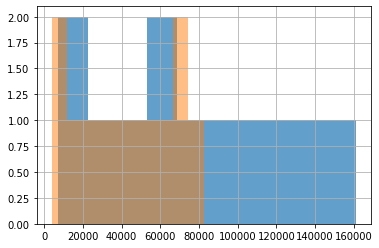

In [70]:
data_smart['total_duration'].hist(bins=10, alpha=0.7)
data_ultra['total_duration'].hist(bins=10, alpha=0.5)

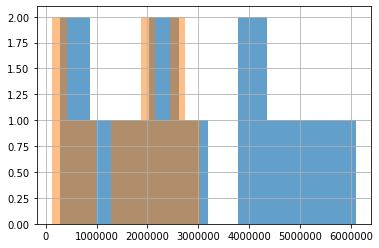

In [71]:
data_smart['mb_used'].hist(bins=10, alpha=0.7)
data_ultra['mb_used'].hist(bins=10, alpha=0.5)

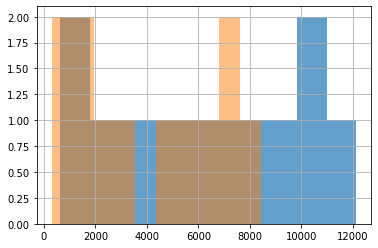

In [72]:
data_smart['messages_quantity'].hist(bins=10, alpha=0.7)
data_ultra['messages_quantity'].hist(bins=10, alpha=0.5)

**Вывод**

По гистограммам можно сделать вывод: пользователи тарифа smart тратять больше услуг на звонки, интернет и сообщения чем пользователи тарифа ultra. Это может быть, потому что пользователей с тарифом smart больше.

In [73]:
# находим среднее, дисперсию и стандартное отклонение для продолжительности звонков 
calls_mean_smart = data_smart['total_duration'].mean()
calls_mean_ultra = data_ultra['total_duration'].mean()

print('Среднее количество минут по тарифу "smart":', calls_mean_smart)
print('Среднее количество минут по тарифу "ultra":', calls_mean_ultra)
print()

calls_disp_smart = np.var(data_smart['total_duration'])
calls_disp_ultra = np.var(data_ultra['total_duration'])

print('Дисперсия по тарифу "smart":', calls_disp_smart)
print('Дисперсия по тарифу "ultra":', calls_disp_ultra)
print()

calls_stand_smart = np.std(data_smart['total_duration'])
calls_stand_ultra = np.std(data_ultra['total_duration'])

print('Стандартное отклонение по тарифу "smart":', calls_stand_smart)
print('Стандартное отклонение по тарифу "ultra":', calls_stand_ultra)

Среднее количество минут по тарифу "smart": 77631.41666666667
Среднее количество минут по тарифу "ultra": 43227.0

Дисперсия по тарифу "smart": 2283675263.576389
Дисперсия по тарифу "ultra": 622097403.0

Стандартное отклонение по тарифу "smart": 47787.81501153185
Стандартное отклонение по тарифу "ultra": 24941.880502480162


In [74]:
# находим среднее, дисперсию и стандартное отклонение для интернета
mb_mean_smart = data_smart['mb_used'].mean()
mb_mean_ultra = data_ultra['mb_used'].mean()

print('Среднее количество мегабайт по тарифу "smart":', mb_mean_smart)
print('Среднее количество мегабайт по тарифу "ultra":', mb_mean_ultra)
print()

mb_disp_smart = np.var(data_smart['mb_used'])
mb_disp_ultra = np.var(data_ultra['mb_used'])

print('Дисперсия по тарифу "smart":', mb_disp_smart)
print('Дисперсия по тарифу "ultra":', mb_disp_ultra)
print()

mb_stand_smart = np.std(data_smart['mb_used'])
mb_stand_ultra = np.std(data_ultra['mb_used'])

print('Стандартное отклонение по тарифу "smart":', mb_stand_smart)
print('Стандартное отклонение по тарифу "ultra":', mb_stand_ultra)

Среднее количество мегабайт по тарифу "smart": 3010613.5833333335
Среднее количество мегабайт по тарифу "ultra": 1598024.8333333333

Дисперсия по тарифу "smart": 3360185584219.576
Дисперсия по тарифу "ultra": 830382251740.3055

Стандартное отклонение по тарифу "smart": 1833080.8995294168
Стандартное отклонение по тарифу "ultra": 911253.1216628591


In [75]:
# находим среднее, дисперсию и стандартное отклонение для сообщений 
mes_mean_smart = data_smart['messages_quantity'].mean()
mes_mean_ultra = data_ultra['messages_quantity'].mean()

print('Среднее количество сообщений по тарифу "smart":', mes_mean_smart)
print('Среднее количество сообщений по тарифу "ultra":', mes_mean_ultra)
print()

mes_disp_smart = np.var(data_smart['messages_quantity'])
mes_disp_ultra = np.var(data_ultra['messages_quantity'])

print('Дисперсия по тарифу "smart":', mes_disp_smart)
print('Дисперсия по тарифу "ultra":', mes_disp_ultra)
print()

mes_stand_smart = np.std(data_smart['messages_quantity'])
mes_stand_ultra = np.std(data_ultra['messages_quantity'])

print('Стандартное отклонение по тарифу "smart":', mes_stand_smart)
print('Стандартное отклонение по тарифу "ultra":', mes_stand_ultra)

Среднее количество сообщений по тарифу "smart": 6201.083333333333
Среднее количество сообщений по тарифу "ultra": 4051.9166666666665

Дисперсия по тарифу "smart": 13173969.243055554
Дисперсия по тарифу "ultra": 7385913.909722224

Стандартное отклонение по тарифу "smart": 3629.596292021408
Стандартное отклонение по тарифу "ultra": 2717.703793595289


## Шаг. Проверка гипотез

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.**

In [76]:
smart_income_mean = data[data['tariff'] == 'smart']['total_income'].mean()
ultra_income_mean = data[data['tariff'] == 'ultra']['total_income'].mean()

data_smart_income = list(data[data['tariff'] == 'smart']['total_income'])
data_ultra_income = list(data[data['tariff'] == 'ultra']['total_income'])

print(smart_income_mean)
print(ultra_income_mean)

alpha = .05

results = st.ttest_ind(
    data_smart_income, 
    data_ultra_income, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

880.5405855748631
2005.2898142937536
p-значение:  0.0
Отвергаем нулевую гипотезу


**Вывод**

Добавим нулевую гипотезу к основной.
Нулевая гипотеза - Средняя выручка пользователей тарифа «Ультра» схожа со средней выручкой пользователей тарифа «Смарт»
Альтернативная гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

С помощью метода ttest_ind() проверяем наши гипотезы, по двум выборкам доходов тарифных планов.
Также вывели средние значения дохода по каждому тарифу. По средним четко видно, что в среднем доходы между тарифами раздичаются. Основная гипотеза подтвердилась.

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

In [77]:
moscow_income_mean = data[data['city'] == 'Москва']['total_income'].mean()
others_income_mean = data[data['city'] != 'Москва']['total_income'].mean()

moscow_income = list(data[data['city'] == 'Москва']['total_income'])
others_income = list(data[data['city'] != 'Москва']['total_income'])

print(moscow_income_mean)
print(others_income_mean)

alpha = .05

results = st.ttest_ind(
    moscow_income, 
    others_income, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1208.621212121212
1216.4319415448851
p-значение:  0.7436121911478546
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Добавим нулевую гипотезу к основной.
Нулевая гипотеза - Средняя выручка пользователей из Москвы такая же как и в других регионах.
Альтернативная гипотеза - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

С помощью того же метода ttest_ind() проверяем вторую гипотезу. По средним значениям и по работе метода видно, что средняя выручка по Москве и другим регионам одинаковая. Наша первоначальная гипотеа отклоняется.

## Шаг. Общий вывод

Задача: "Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег."

В результате обработки данных по использованным услугам среди 500 пользователей, мы объеденили 4 таблицы (использованный интернет-трафик, продолжительность звонков, количество отправленных сообщений и список пользователей, по которым мы получили информацию во всех таблицах). Обеденив данные мы получили небольшую таблицу с пользователями и потраченными ими услугами помесячно.

Пользватели тарифа Smart пользуются предоставленными услугами намного активнее пользователей тарифа Ultra. Скорей всего, потому что пользвателей тарифа Smart больше.
А если рассмотреть средних доход по Москве и другим регионам отдельно, мы видим, что город не влияет на прибыль.
Проверив наши гипотезы, получем:

* Тариф Ultra приносит больший доход, хоть у него меньше пользователей.
* Независимо от того в каком городе рассмтаривать прибыль, она будет примерно на одном уровне.
